In [1]:
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from IPython.display import clear_output
from tqdm import tqdm
import copy
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

%matplotlib inline

Cartesian = lambda x,y: np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
AddZ = lambda x: np.concatenate((x, np.zeros((x.shape[0], x.shape[1], 1))), axis=2)

Mounted at /content/drive


In [2]:
def Freq(Data = None):
  YantData = scipy.io.loadmat('/content/drive/MyDrive/AntData/YantData.mat')['YantData'].flatten()
  res = np.array([YantData[i].shape[0] for i in range(YantData.shape[0])])
  return res

def Cluster(Z,Y,plot = False):
    data = np.column_stack((Z, Y))
    centers = Cartesian(np.array([-25,-8,8,25]),np.array([-25,-8,8,25]))
    kmeans = KMeans(n_clusters=16, init=centers)
    kmeans.fit(data)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    if plot:
      plt.figure(figsize=(12, 7))
      plt.title(f"Num of antennas: {Z.shape[0]}")
      plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
      plt.scatter(centers[:, 0], centers[:, 1], marker='X',c='red', s=100, label='Centers')
      plt.grid()
      plt.show()

    return data, labels

def SmartPadding(Y,Z,i, flatten = True):
  Y, Z = Y[i][0].flatten(),Z[i][0].flatten()
  data, labels = Cluster(Z,Y)

  pad_data = None

  for l in range(16):
    labeled_data = np.vstack((data[labels == l], np.zeros((64 - np.sum(labels == l), 2))))
    pad_data = np.vstack((pad_data, labeled_data)) if pad_data is not None else labeled_data

  if flatten:
      return pad_data.flatten()
  else:
      return pad_data

def NoPadding(Z,Y,i):
    data = np.column_stack((np.squeeze(Z[i]), np.squeeze(Y[i])))
    return data.flatten()

def CreateData(mask = None):
    #For 3D data please: 1. Change to faltten = False, 2. Add the Add Z function in the end of the return, 3. Shout loudly: kulululu!
    YantData = scipy.io.loadmat('/content/drive/MyDrive/AntData/YantData.mat')['YantData']
    ZantData = scipy.io.loadmat('/content/drive/MyDrive/AntData/ZantData.mat')['ZantData']

    cost = scipy.io.loadmat('/content/drive/MyDrive/AntData/cost.mat')['cost'].squeeze()

    freq = Freq(YantData)
    if mask:
      YantData,ZantData,cost = YantData[freq == mask],ZantData[freq == mask],cost[freq == mask]
      data_list = [NoPadding(ZantData, YantData, i) for i in tqdm(range(ZantData.shape[0]))]
    else:
      data_list = [SmartPadding(ZantData, YantData, i, flatten = True) for i in tqdm(range(ZantData.shape[0]))]

    del YantData
    del ZantData

    return np.array(data_list), cost

def result(preds, reals):
  N = preds.shape[0]

  res = {'MPE':0,  '< 1%':0, '< 5%':0, '< 10%':0, '< 15%':0, '< 25%':0, '< 50%':0}


  for pred, real in zip(preds, reals):
    percentage_error = np.abs((pred - real)/ real) * 100
    try:
      res['MPE'] += (percentage_error / N)[0]
    except:
      res['MPE'] += (percentage_error / N)
    for i in [1,5,10,15,25,50]:
      res[f"< {i}%"] += 100 / N if percentage_error <= i else 0

  return res

result_table = lambda train_result, test_result: print(tabulate([['Train']+list(train_result.values()), ['Test']+list(test_result.values())], headers=list(train_result.keys()), tablefmt='pipe'))

def eval(model, X_train, X_test, y_train, y_test):
  train_predictions = model.predict(X_train, verbose = 0)
  test_predictions = model.predict(X_test, verbose = 0)

  train_result = result(train_predictions, y_train)
  test_result = result(test_predictions, y_test)

  #clear_output(wait = True)

  result_table(train_result, test_result)

In [3]:
mask = None
Data, cost = CreateData(mask = mask)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Data, cost, test_size=0.3, random_state=42)

del Data
del cost

100%|██████████| 103201/103201 [04:04<00:00, 422.00it/s]


Epoch 1/200
2258/2258 [==============================] - 29s 10ms/step - loss: 16648932352.0000 - val_loss: 1444278.3750
Epoch 2/200
2258/2258 [==============================] - 21s 9ms/step - loss: 1638202.8750 - val_loss: 1545109.5000
Epoch 3/200
2258/2258 [==============================] - 21s 9ms/step - loss: 1607840.3750 - val_loss: 1817004.1250
Epoch 4/200
2258/2258 [==============================] - 22s 10ms/step - loss: 1363110.6250 - val_loss: 650418.9375
Epoch 5/200
2258/2258 [==============================] - 22s 10ms/step - loss: 1294368.3750 - val_loss: 2928428.0000
Epoch 6/200
2258/2258 [==============================] - 22s 10ms/step - loss: 1421993.2500 - val_loss: 773256.9375
Epoch 7/200
2258/2258 [==============================] - 22s 10ms/step - loss: 1199858.3750 - val_loss: 2497644.5000
Epoch 8/200
2258/2258 [==============================] - 21s 9ms/step - loss: 994490.0625 - val_loss: 799395.0625
Epoch 9/200
2258/2258 [==============================] - 21s 9ms/st

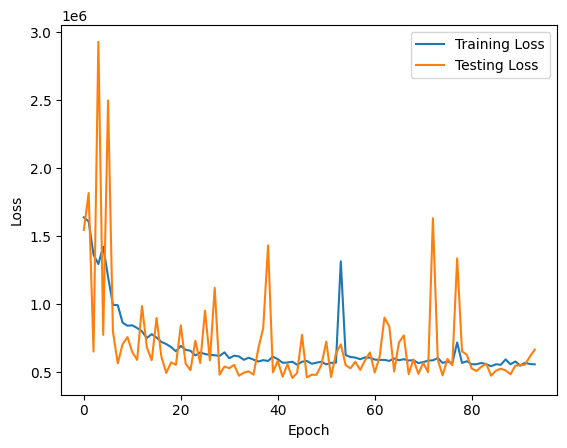



|       |     MPE |    < 1% |    < 5% |   < 10% |   < 15% |   < 25% |   < 50% |
|:------|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
| Train | 29.0286 | 11.0022 | 45.8347 | 65.9911 | 74.3812 | 82.4446 | 90.1661 |
| Test  | 29.6191 | 10.7619 | 45.3926 | 65.9766 | 74.4873 | 82.7945 | 90.2813 |


In [4]:
input_size = mask * 2 if mask else 2048

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(input_size, activation='relu', input_shape=(input_size,)),
    tf.keras.layers.Dense(input_size, activation='relu'),
    tf.keras.layers.Dense(input_size, activation='relu'),
    tf.keras.layers.Dense(input_size, activation='relu'),
    tf.keras.layers.Dense(input_size, activation='relu'),
    tf.keras.layers.Dense(input_size, activation='relu'),
    tf.keras.layers.Dense(input_size, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

print("\n==========================\n")

# Get the training and testing loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and testing loss
plt.plot(train_loss[1:], label='Training Loss')
plt.plot(val_loss[1:], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("\n==========================\n")

eval(model, X_train, X_test, y_train, y_test)

2 Hidden layers:

|       |     MPE |    < 1% |    < 5% |   < 10% |   < 15% |   < 25% |   < 50% |
|:------|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
| Train | 32.5762 | 11.1337 | 47.0612 | 68.0094 | 76.3884 | 83.6849 | 89.6816 |
| Test  | 33.2049 | 11.2012 | 46.9009 | 67.7659 | 76.8095 | 83.8829 | 89.9906 |

6 Hidden layers:

|       |     MPE |    < 1% |    < 5% |   < 10% |   < 15% |   < 25% |   < 50% |
|:------|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
| Train | 29.0286 | 11.0022 | 45.8347 | 65.9911 | 74.3812 | 82.4446 | 90.1661 |
| Test  | 29.6191 | 10.7619 | 45.3926 | 65.9766 | 74.4873 | 82.7945 | 90.2813 |